In [1]:
!git clone --recursive https://github.com/bemc22/ModuloSEFL
%cd ModuloSEFL
!pip install ./deepinv/

Cloning into 'ModuloSEFL'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 56 (delta 17), reused 39 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (56/56), 9.12 MiB | 13.14 MiB/s, done.
Resolving deltas: 100% (17/17), done.
Submodule 'deepinv' (https://github.com/deepinv/deepinv) registered for path 'deepinv'
Cloning into '/content/ModuloSEFL/deepinv'...
remote: Enumerating objects: 26737, done.        
remote: Counting objects: 100% (18/18), done.        
remote: Compressing objects: 100% (18/18), done.        
remote: Total 26737 (delta 8), reused 0 (delta 0), pack-reused 26719 (from 1)        
Receiving objects: 100% (26737/26737), 227.53 MiB | 30.63 MiB/s, done.
Resolving deltas: 100% (20030/20030), done.
Submodule path 'deepinv': checked out '891ab036ac4033c30a6b9ad71ed1c560b4355433'
/content/ModuloSEFL
Processing ./deepinv
  Installing build dependencies ... done
  Get

In [2]:
import os
import torch
import deepinv as dinv
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from deepinv.utils.demo import load_example

In [48]:
def channel_norm(x):
    x = x - x.min(dim=-1, keepdim=True)[0].min(dim=-2, keepdim=True)[0]
    x = x / x.max(dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0]
    return x


size = 256
dynamic_range = 4  # dynamic range
threshold = 1.0  # threshold for spatial unwrapping
device = "cuda" if torch.cuda.is_available() else "cpu"
img_size = (size, size)
mode = "floor"  # available modes: "round", "floor"


x_rgb = load_example(
    "CBSD_0010.png",
    grayscale=False,
    device=device,
    dtype=torch.float32,
    img_size=img_size,
)

x_rgb = channel_norm(x_rgb) * dynamic_range

In [49]:
factor = 3
resize = transforms.Resize(size=(img_size[0] * factor, img_size[1] * factor))
x_rgb = resize(x_rgb)


filter_0 = dinv.physics.blur.gaussian_blur(sigma=(1, 1), angle=0.0)
blur_op = dinv.physics.Blur(filter_0, device=device)
x_rgb = blur_op(x_rgb)

In [50]:
physics = dinv.physics.SpatialUnwrapping(
    threshold=threshold, mode=mode
).to(device)


modulo_image = physics(x_rgb)

In [51]:
from models import ModuloSEFLnet

in_channels = modulo_image.shape[1]
model =  ModuloSEFLnet(mx=threshold, in_channels=in_channels, out_channels=in_channels).to(device)
model.load_state_dict(torch.load(os.path.join("ckpts", "ModuloSEFLnet.pth")))

<All keys matched successfully>

In [52]:
psnr_fn = dinv.loss.metric.PSNR(max_pixel=dynamic_range)
ssim_fn = dinv.loss.metric.SSIM(max_pixel=dynamic_range)

with torch.no_grad():
    x_rec = model(modulo_image)
    psnr = psnr_fn(x_rec, x_rgb).item()
    ssim = ssim_fn(x_rec, x_rgb).item()
    print(f"PSNR: {psnr:.2f} dB, SSIM: {ssim:.4f}")

PSNR: 16.85 dB, SSIM: 0.8371


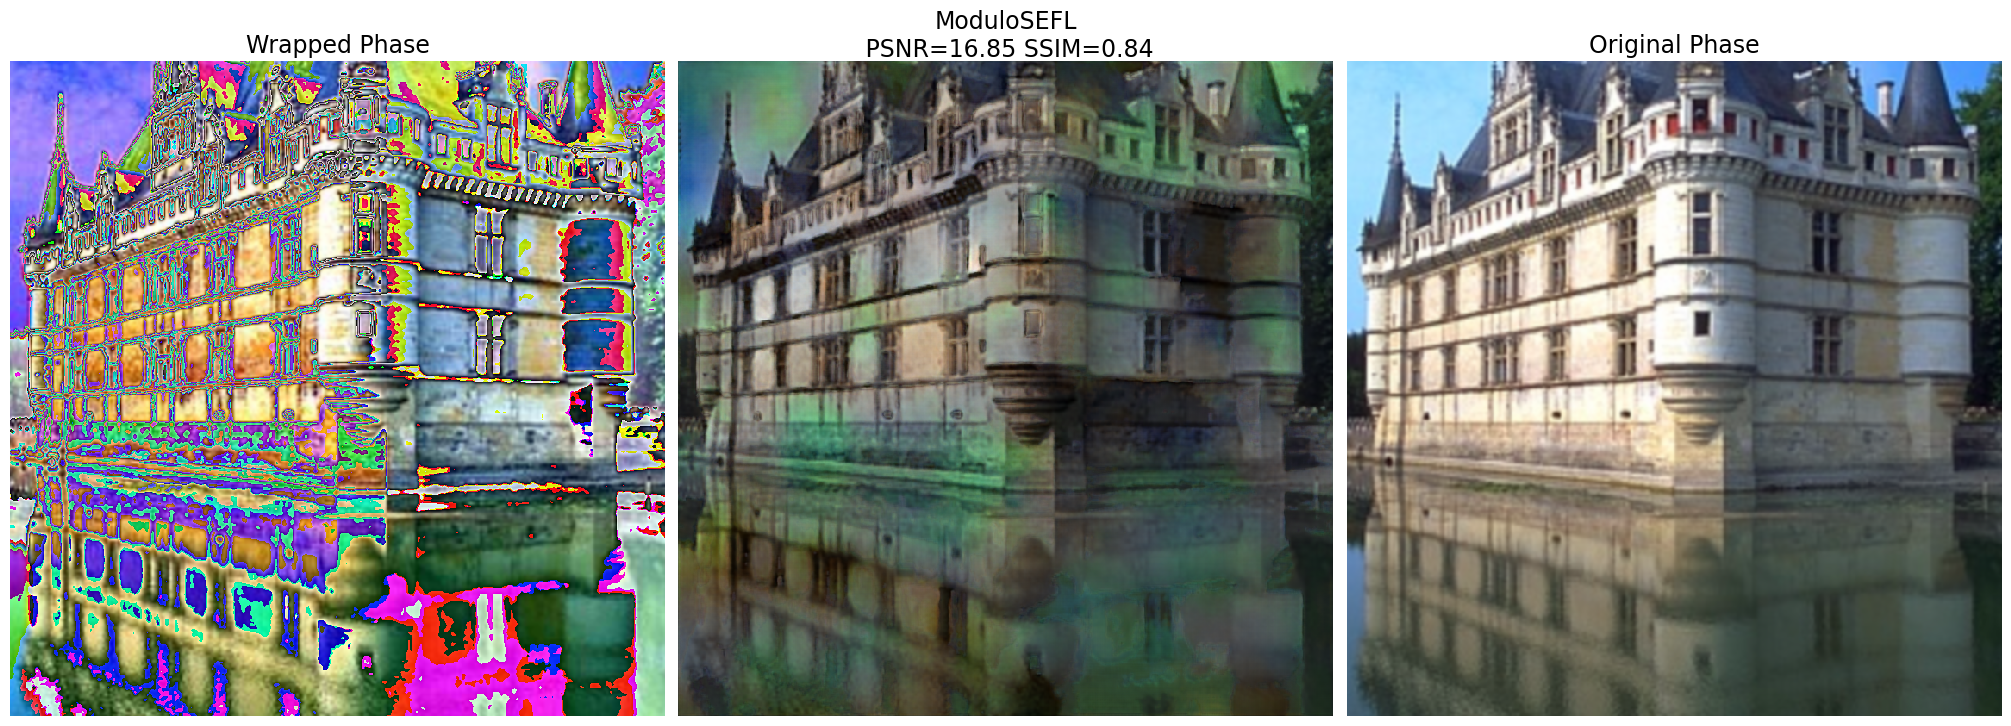

In [53]:
# Plot results

imgs = [modulo_image[0],  x_rec[0], x_rgb[0]]
titles = [
    "Wrapped Phase",
    f"ModuloSEFL\n PSNR={psnr:.2f} SSIM={ssim:.2f}",
    "Original Phase",
]

dinv.utils.plotting.plot(imgs, titles=titles, cmap="gray", figsize=(20, 10))